In [1]:
using DrWatson
@quickactivate "Attitude Control"

In [2]:
include("../src/dynamics.jl")
using Plots
using LinearAlgebra
using DiffEqCallbacks

In [3]:
function state_feedback(int)
    # Disregard the real part of the quaternion
    x = int.u[2:7]
    
    # Negative state feedback
    K = -1e-3*[I(3) I(3)] 
    
    #Control output -- assuming some actuator without momentum buildup
    int.p.u = K*x
end

state_feedback (generic function with 1 method)

In [4]:
q0 = randn(4); q0 = q0 / norm(q0);
ω0 = randn(3); ω0 = ω0 / norm(ω0) * deg2rad(1);

J = [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.4]
x0 = [q0; ω0]
sol = SpacecraftModel.run_simulation(x0, J, 1500, PeriodicCallback(state_feedback, 1));

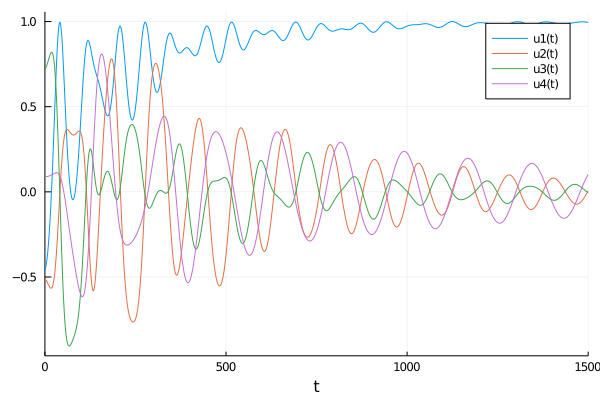

In [5]:
plot(sol, vars=(1:4))

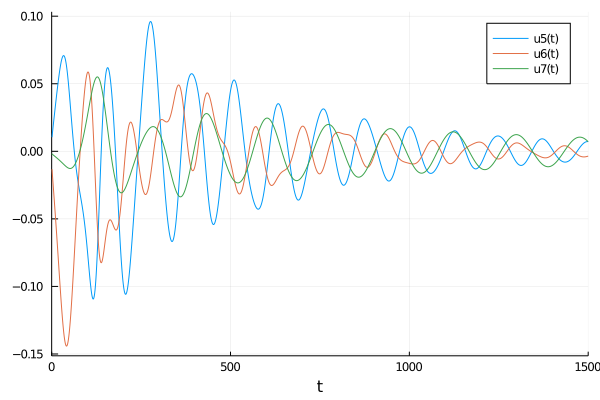

In [6]:
plot(sol, vars=(5:7))